In [1]:
import os
import torch
import random
import numpy as np
from torch import nn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision import datasets, models
from torch.utils.data import random_split, DataLoader

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # use seed "42"

(729, 486)


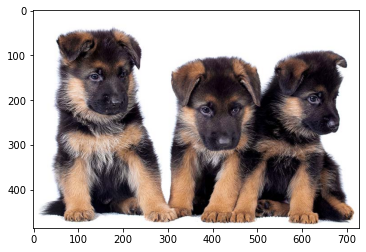

In [2]:
img = Image.open('test_images/puppies.jpg')
print(img.size)
plt.imshow(img)

(224, 224)


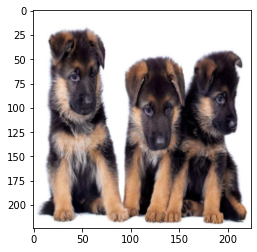

In [3]:
resized = T.Resize((224, 224))(img)
print(resized.size)
plt.imshow(resized)

(729, 486)


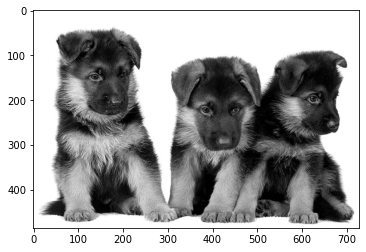

In [4]:
gray = T.Grayscale()(img)
print(gray.size)
plt.imshow(gray, cmap='gray')

(200, 200)


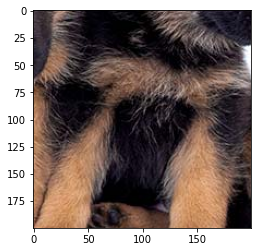

In [5]:
cropped = T.RandomCrop((200, 200))(img)
print(cropped.size)
plt.imshow(cropped)

(729, 486)


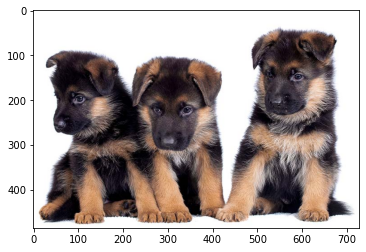

In [6]:
flipped = T.RandomHorizontalFlip(p=1.0)(img)
print(flipped.size)
plt.imshow(flipped)

(729, 486)


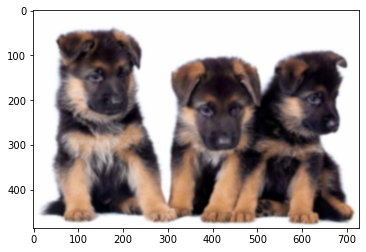

In [7]:
blurred = T.GaussianBlur(kernel_size=101)(img)
print(blurred.size)
plt.imshow(blurred)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 2
img_size = 224
batch_size = 64
num_classes = 10
lr = 3e-4

# preprocessing
train_transform = T.Compose(
    [
     T.Resize((int(img_size*1.5), int(img_size*1.5))),

     T.RandomCrop((img_size, img_size)),

     T.RandomHorizontalFlip(p=0.5),

     T.ToTensor()
    ]
)

# preprocessing: to get an unbiased prediction from the neural net
test_transform = T.Compose(
    [
     T.Resize((img_size, img_size)),

     T.ToTensor()
    ]
)

print(device)

cpu


In [9]:
data = datasets.CIFAR10("data/", train=True, transform=train_transform) # preprocessing
test_data = datasets.CIFAR10("data/", train=False, transform=test_transform) # preprocessing

use_len = 500 # using only 500 images from the data for demo purpose
test_use_len = 100 # using only 100 images from the test data for demo purpose

used_data, unused_data = random_split(data, [use_len, len(data) - use_len])
used_test_data, unused_test_data = random_split(test_data, [test_use_len, len(test_data) - test_use_len])

print(len(used_data), len(used_test_data))

500 100


In [11]:
train_len = int(0.7 * len(used_data)) # 70% of the data is for training, remaining 30% is for validation
train_data, val_data = random_split(used_data, [train_len, len(used_data) - train_len])

test_data = used_test_data

print(len(train_data), len(val_data), len(test_data))

350 150 100


In [12]:
class_list = data.classes
print(class_list)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


torch.Size([3, 224, 224]) horse


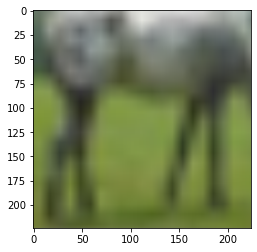

In [14]:
img, label = train_data[10]
print(img.shape, class_list[label])
plt.imshow(img.permute(1, 2, 0)) # looking at an image

In [15]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # splitting the data into batches
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False) # splitting the data into batches
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False) # splitting the data into batches

batch = next(iter(train_loader)) # grabbing a batch of the data
x, y = batch
print(x.shape, y.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


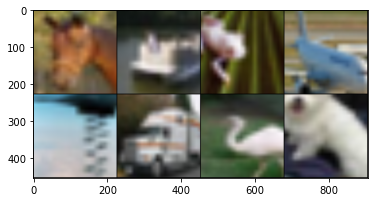

In [16]:
grid_x = x[:8]
grid_img = make_grid(grid_x, nrow=4) # making a grid of images
plt.imshow(grid_img.permute(1, 2, 0)) # looking at a batch of images

In [17]:
net = models.resnet18(pretrained=True) # algorithm/neural net/model
net.fc = nn.Linear(net.fc.in_features, num_classes) # don't worry about this right now, this is algorithm-centric stuff, we will we cover this in the future webinars
net = net.to(device)

In [18]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # makes the algorithm better
loss_fn = nn.CrossEntropyLoss() # calculates how good or bad the algorithm is doing

# postprocesssing
def get_accuracy(preds, y):
    preds = preds.argmax(dim=1, keepdim=True) # postprocesssing
    correct = preds.squeeze(1).eq(y)
    acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
    return acc

In [19]:
def loop(net, loader, is_train, epoch=None):
    net.train(is_train)
    losses = []
    accs = []

    if is_train:
        split = 'train'
    else:
        split = ' val '

    pbar = tqdm(loader, total=len(loader)) # iterating over batches using tqdm progress bar
    for x, y in pbar:
        x = x.to(device) # mounting images onto device
        y = y.to(device) # mounting labels onto device

        with torch.set_grad_enabled(is_train):
            preds = net(x) # getting the prediction from the algorithm
            loss = loss_fn(preds, y) # postprocesssing(softmax)
            acc = get_accuracy(preds, y) # postprocesssing(argmax)
            
            losses.append(loss.item()) # keeping track of the loss values
            accs.append(acc.item()) # keeping track of the accuracy values
            
        if is_train:
            optimizer.zero_grad() 
            loss.backward() # backpropagation i.e. learning part of the algorithm
            optimizer.step()
        
        if epoch != None:
            pbar.set_description(f'{split}: epoch={epoch}, loss={np.mean(losses):.4f}, acc={np.mean(accs):.4f}') # displaying metrics
        else:
            pbar.set_description(f'loss={np.mean(losses):.4f}, acc={np.mean(accs):.4f}') # displaying metrics

In [20]:
for epoch in range(n_epochs): # looping for n_epochs number of times
    loop(net, train_loader, True, epoch) # training
    loop(net, val_loader, False, epoch) # validation

 val : epoch=1, loss=1.6701, acc=0.3707: 100%|███████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]


In [21]:
loop(net, test_loader, False) # testing

loss=1.5316, acc=0.4531: 100%|███████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.08s/it]


In [22]:
@torch.no_grad()
def predict(img):
    net.eval()
    img = Image.open(img).convert("RGB")
    img = test_transform(img).to(device) # preprocesssing
    pred = net(img.unsqueeze(0))
    pred = pred.argmax(dim=1) # postprocesssing
    print(class_list[pred.item()]) # postprocesssing

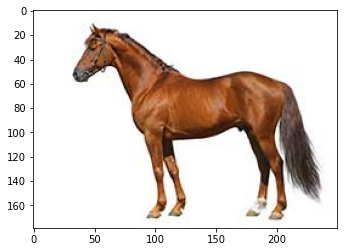

In [23]:
img = Image.open('test_images/horse.jpg')
plt.imshow(img)

In [24]:
predict('test_images/puppies.jpg')

bird


In [25]:
predict('test_images/horse.jpg')

horse
